In [2]:
%%capture
from warnings import filterwarnings
filterwarnings('ignore')
import os, sys, contextlib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# with open(os.devnull, 'w') as f, contextlib.redirect_stderr(f):
#     import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Conv3D,\
Conv2D, Dense,\
MaxPool2D, MaxPool3D,\
Flatten, Dropout
from keras.layers import BatchNormalization,GlobalAveragePooling3D,ReLU,Input
from keras.callbacks import EarlyStopping
import pandas as pd, numpy as np, os, cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.metrics import AUC
from keras.optimizers import Nadam

E0000 00:00:1756341762.333065 1217427 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756341762.335823 1217427 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756341762.342872 1217427 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756341762.342883 1217427 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756341762.342884 1217427 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756341762.342885 1217427 computation_placer.cc:177] computation placer already registered. Please check linka

In [4]:
df = pd.read_csv('../datasrc/volumeOCT_metadata.csv')
filelist = list(df.filename)
fpaths = [ os.path.join('../datasrc/volumesOCT/',n) for n in filelist ]
vols = [ np.load(ip) for ip in fpaths ]
vols[0].shape

# X = list of volume arrays (shape: N x 64 x 128 x 64)
X = np.array(vols)  # shape: (N, 64, 128, 64)
X = X[..., np.newaxis]  # add channel dim → (N, 64, 128, 64, 1)

# y = encoded labels
y = LabelEncoder().fit_transform(df['dx_class'])  # e.g., Glaucoma=1, Normal=0
y = pd.get_dummies(df.dx_class).astype(int).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

In [6]:
X.shape

(1110, 64, 128, 64, 1)

In [12]:
y

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [5]:
import gc, subprocess
from keras import backend as K

def gpUSERS(n=2):
    output = subprocess.check_output(['nvidia-smi'], text=True)
    lines = output.splitlines()
    users = []

    for line in lines:
        if any(unit in line for unit in ['MiB', 'GiB']) and '/' in line:
            parts = line.split('|')
            if len(parts) >= 4:
                users.append(parts[n].strip())  # This is usually the process name or user

    return users

def gpuMEM(capfrac=.15):
    use = gpUSERS()[0].split('MiB /')[0]
    use = int(use)
    cap = int(gpUSERS()[0].split('MiB /')[1].replace('MiB',''))
    threshold = int(cap * capfrac)
    return use,cap,threshold

gpuMEM()

(155, 12282, 1842)

In [ ]:


# midslices = [ v[32,:,:] for v in vols ]
# # plt.imshow(midslices[120])

# X = np.array(midslices)
# X = X[...,np.newaxis]

# model = Sequential([
#     Conv2D(16, kernel_size=(4,4),activation='relu',input_shape=X[0].shape),
#     Flatten(), Dense(32,activation='relu'),
#     Dropout(.3), Dense(1, activation='sigmoid')
# ])

# print(gpuMEM)

In [55]:
help(Input)

Help on function Input in module keras.src.layers.core.input_layer:

Input(shape=None, batch_size=None, dtype=None, sparse=None, ragged=None, batch_shape=None, name=None, tensor=None, optional=False)
    Used to instantiate a Keras tensor.

    A Keras tensor is a symbolic tensor-like object, which we augment with
    certain attributes that allow us to build a Keras model just by knowing the
    inputs and outputs of the model.

    For instance, if `a`, `b` and `c` are Keras tensors,
    it becomes possible to do:
    `model = Model(input=[a, b], output=c)`

    Args:
        shape: A shape tuple (tuple of integers or `None` objects),
            not including the batch size.
            For instance, `shape=(32,)` indicates that the expected input
            will be batches of 32-dimensional vectors. Elements of this tuple
            can be `None`; `None` elements represent dimensions where the shape
            is not known and may vary (e.g. sequence length).
        batch_size:

In [56]:
mui,mci,_ = gpuMEM()
print(f"\033[1mMemory Use (before model instantiation): \033[36m{mui}\033[0m\033[1m MiB / {mci} MiB\033[0m")

model = Sequential([

    Input(shape=(64, 128, 64, 1)),
    # Layer 1
    Conv3D(32, kernel_size=7, strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 2
    Conv3D(32, kernel_size=5, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 3
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 4
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 5
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Global Average Pooling
    GlobalAveragePooling3D(),

    # Dense → Softmax (for multi-class CAM support)
    Dense(2, activation='softmax')  # use 1 + sigmoid if binary
])

muf,mcf,_ = gpuMEM()
print(f"\033[1mMemory Use (after model instantiation): \033[36m{muf}\033[0m\033[1m MiB / {mcf} MiB\033[0m")

early_stop = EarlyStopping(
    monitor='val_loss',      # or 'val_auc' if you want to prioritize AUC
    patience=3,
    restore_best_weights=True
)

model.compile(
    optimizer=Nadam(learning_rate=1e-4),
    metrics=['accuracy',AUC(name='auc')],
    loss='binary_crossentropy'
)

history = model.fit(
    X_train,y_train, 
    validation_data=(X_test,y_test), 
    epochs=100,
    batch_size=8,
    callbacks=[early_stop]
)

Memory Use (before model instantiation): 10743 MiB / 12282 MiB
Memory Use (after model instantiation): 10743 MiB / 12282 MiB
Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.6233 - auc: 0.6910 - loss: 0.6448 - val_accuracy: 0.3243 - val_auc: 0.3698 - val_loss: 0.8943
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8095 - auc: 0.8743 - loss: 0.5405 - val_accuracy: 0.3243 - val_auc: 0.3753 - val_loss: 0.9528
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8113 - auc: 0.8783 - loss: 0.5186 - val_accuracy: 0.7027 - val_auc: 0.7128 - val_loss: 0.6240
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.7866 - auc: 0.8830 - loss: 0.5060 - val_accuracy: 0.7928 - val_auc: 0.8652 - val_loss: 0.5197
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8066 - auc: 0.8812 - loss: 0.4952 - val_accuracy: 0.8108 - val_auc: 0.9133 - val_loss: 0.4342
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy

In [57]:
# import matplotlib.pyplot as plt
loss,acc,auc = model.evaluate(X_test,y_test)

saved_epoch = [ i for i,v in enumerate(history.history['val_auc']) if v == auc ][0]

saved_epoch

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.8456 - auc: 0.9236 - loss: 0.3529


14

Text(0.5, 1.0, 'AUC over Epochs')

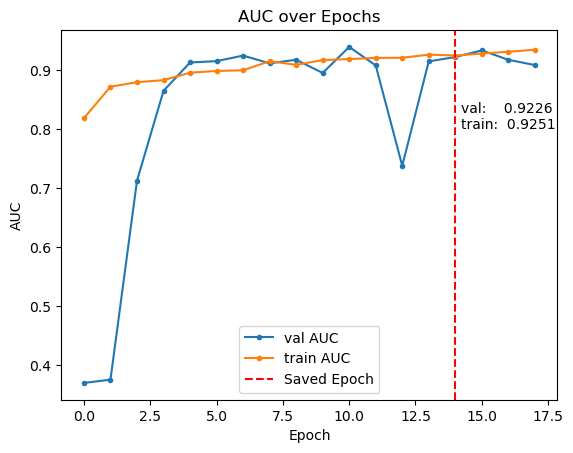

In [58]:
plt.plot(history.history['val_auc'], label='val AUC', marker='.')
plt.plot(history.history['auc'], label='train AUC', marker='.')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.axvline(saved_epoch, linestyle='--', c='r', label='Saved Epoch')
plt.text(saved_epoch+.2,.8,f"val:    {auc:.4f}\ntrain:  {history.history['auc'][saved_epoch]:.4f}")
plt.legend()
plt.title('AUC over Epochs')

Text(0.5, 1.0, 'Accuracy over Epochs')

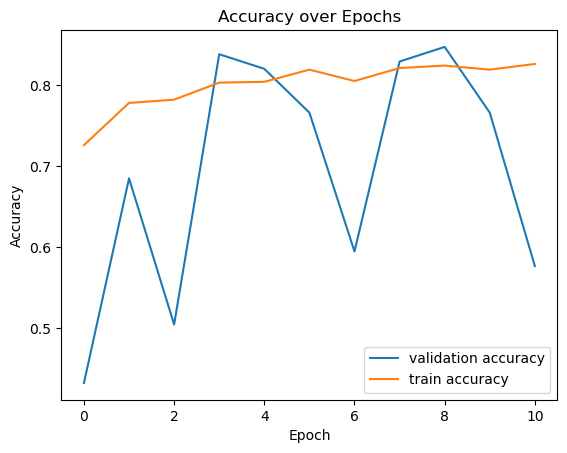

In [9]:
# import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

In [60]:
sample = X_test[0][np.newaxis,...]
pred = model.predict(sample)
print(pred)
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[3.549921e-04 9.996450e-01]]


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_10 (Conv3D)              │ (None, 32, 64, 32, 32) │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 64, 32, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 32, 64, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 32, 64, 32, 32) │       128,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 64, 32, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 32, 64, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_12 (Conv3D)              │ (None, 32, 64, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 64, 32, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 32, 64, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_13 (Conv3D)              │ (None, 32, 64, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 64, 32, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 32, 64, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_14 (Conv3D)              │ (None, 32, 64, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 64, 32, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 32, 64, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 667,721 (2.55 MB)

 Trainable params: 222,466 (869.01 KB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 444,935 (1.70 MB)

In [87]:
X_test[0].shape

(64, 128, 64, 1)

In [89]:
X_test[0].reshape(64,128,64).shape

(64, 128, 64)

In [90]:
np.squeeze(X_test[0]).shape

(64, 128, 64)

In [111]:
# n rows by 3 cols
def flatMap(nrows,ncols,opf='dict'):
    rowIndices = [ r for r in range(nrows) ]
    colIndices = [ c for c in range(ncols) ]
    nflat = nrows * ncols
    flatIndices = [ f for f in range(nflat) ]
    fMap = []
    ci = 0
    ri = 0 
    for fi in flatIndices:
        item = (fi,(ri,ci))
        fMap.append(item)
        ci += 1
        if ci == ncols:
            ci = 0
            ri += 1

    if opf == 'basic':
        return fMap
    elif opf == 'dict':
        return dict(fMap)
    elif opf == 'df':
        return pd.DataFrame(dict(fMap))
    elif opf == 'tvfn': #two-variable function of r,c
        def tvfn(row,col):
            fiMatches = [ k for k,(r,c) in dict(fMap).items() if r==row and c==col ]
            if len(fiMatches) == 1:
                return fiMatches[0]
        return tvfn
        
        

tvfn = flatMap(111,3,opf='tvfn')

tvfn(3,0)

        
        
        

9

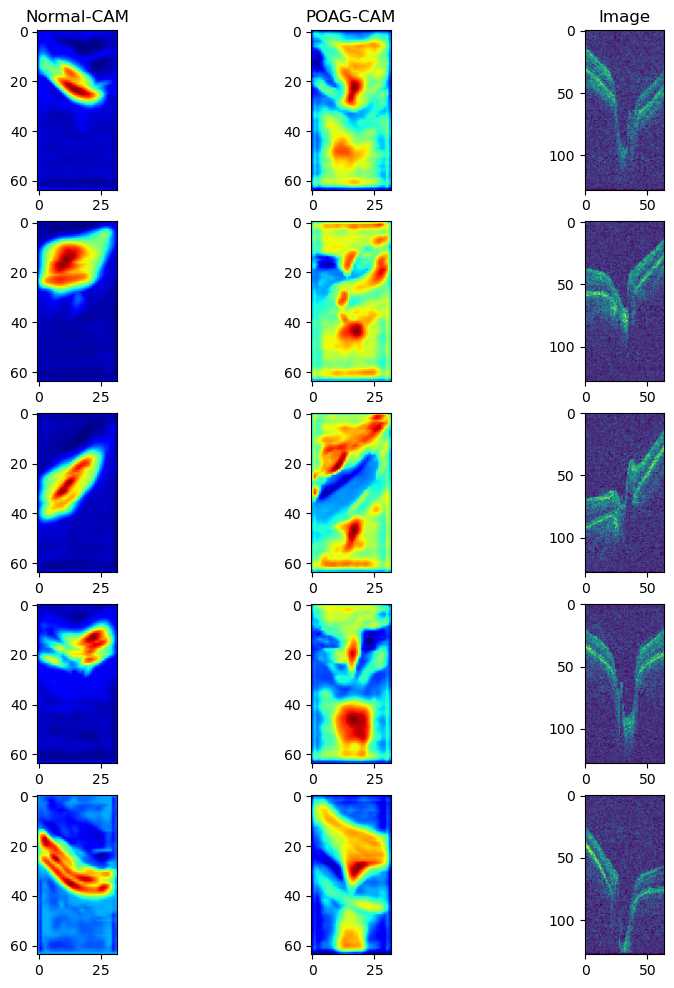

In [150]:
def plotCAM(sample=0, classIndex=1, model=model,ax=None):
    from keras import Model as kerasModel
    
    if type(sample) == int:
        if sample < len(X_test):
            sample = X_test[sample][np.newaxis,...]
    lastConv = kerasModel(
        inputs=model.layers[0].input,
        outputs=model.layers[-3].output
    )
    
    finDenseWts = model.layers[-1].weights[0].numpy()
    
    featMaps = lastConv(sample)
    featMaps = featMaps[0].numpy()
    
    cam = np.tensordot(featMaps, finDenseWts[:,classIndex],axes=([3],[0]))

    if ax:
        ax.imshow(np.max(cam, axis=0), cmap='jet')
    else:
        plt.imshow(np.max(cam, axis=0), cmap='jet')
        plt.title("Class Activation Map (CAM)")
        plt.colorbar()



viran = range(10,15)
# viran = np.random.choice(range(111),size=5,replace=False)
# viran.sort()
# viran = list(viran)

nvols = len(viran)
ncols = 3

fm = flatMap(nvols,ncols=ncols,opf='dict')
tvfn = flatMap(nvols,ncols=ncols,opf='tvfn')


fig,axs = plt.subplots(nvols,ncols,figsize=(10,12))
axes = axs.flatten()
colTitles = "Normal-CAM POAG-CAM Image".split(' ')
for j,title in enumerate(colTitles):
    axs[0,j].set_title(title)
for vi in viran:
    i = viran.index(vi)
    plotCAM(vi, classIndex=0, ax=axes[tvfn(i,0)])
    
    plotCAM(vi, classIndex=1, ax=axes[tvfn(i,1)])
    axes[tvfn(i,2)].imshow(X_test[vi].squeeze()[32,:,:])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


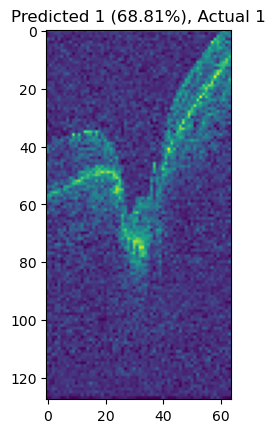

In [80]:
def valid(i,si=32,show=True):
    midB = [ v[si,:,:] for v in vols ]
    Xb = np.array(midB)
    trueLabel = y[i]
    # predictions = model.predict(np.expand_dims(Xb,axis=0))
    predProb = model.predict(Xb[i][np.newaxis,...])
    predLabel = round(float(predProb))
    
    if show:
        plt.imshow(Xb[i])
        plt.title(f"Predicted {predLabel} ({float(predProb)*100:.2f}%), Actual {trueLabel}")

valid(392)

In [43]:
gpuMEM()

(10743, 12282, 1842)

In [24]:
gpuMEM()

(10467, 12282, 1842)

##### stuff 

In [4]:
# model = Sequential([
#     Conv3D(16, kernel_size=(3,3,3), activation='relu', input_shape=(64,128,64,1)),
#     MaxPool3D(pool_size=(2,2,2)),

#     Conv3D(32, (3,3,3), activation='relu'),
#     MaxPool3D((2,2,2)),

#     Conv3D(64, (3,3,3), activation='relu'),
#     MaxPool3D((2,2,2)),

#     Flatten(),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')  # binary classification
# ])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=8)

In [5]:
# def ntuple(value:int=3,n:int=3):
#     vstr = str(value)+' '
#     vstrList = (vstr*n).strip().split(' ')
#     vintList = [ int(vs) for vs in vstrList ]
#     return tuple(vintList)

# ntuple(7)

In [6]:
# kernSizes = [ ntuple(i) for i in range(7,1,-2) ]
# kernSizes.extend([ntuple(3) for a in range(3)])
# # kernSizes

In [7]:
# cnnLayers = []

# for i,ks in enumerate(kernSizes):
#     if i == 0:
#         layer = Conv3D(32, 
#                        kernel_size=ks, 
#                        activation='relu', 
#                        input_shape=(64,128,64,1)
#                       )
#     else:
#         layer = Conv3D(32, 
#                        kernel_size=ks, 
#                        activation='relu'
#                       )
#     cnnLayers.append(layer)
#     cnnLayers.append(MaxPool3D(pool_size=(2,2,2)))

# finalLayers = [
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ]

# cnnLayers.extend(finalLayers)

# len(cnnLayers)

##### main 

In [14]:
import multiprocessing

def train_model():
    from keras.models import Sequential
    from keras.layers import Conv3D, Flatten, Dense
    
    model = Sequential([
        Conv3D(16, kernel_size=(7,7,7), activation='relu', input_shape=(64,128,64,1)),
        MaxPool3D((2,2,2)),
    
        Conv3D(32, (5,5,5), activation='relu'),
        MaxPool3D((2,2,2)),
    
        Conv3D(64, (3,3,3), activation='relu'),
        Conv3D(64, (3,3,3), activation='relu'),
        Conv3D(64, (3,3,3), activation='relu'),
        Conv3D(64, (3,3,3), activation='relu'),
    
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # binary classification
    ])
    cb = EarlyStopping(monitor='val_accuracy',patience=3)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, 
              validation_data=(X_test, y_test), 
              epochs=10, 
              callbacks=[cb], 
              batch_size=8)


p = multiprocessing.Process(target=train_model)
p.start()
p.join()

I0000 00:00:1752331519.216781 1281453 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10095 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/10


I0000 00:00:1752331520.599701 1292483 service.cc:152] XLA service 0x739978003260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752331520.599726 1292483 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-07-12 10:45:20.622006: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752331520.779072 1292483 cuda_dnn.cc:529] Loaded cuDNN version 90700
2025-07-12 10:45:21.517191: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-12 10:45:21.595076: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution

  5/111 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5804 - loss: 10.1172

I0000 00:00:1752331524.791885 1292483 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6742 - loss: 2.1973

2025-07-12 10:45:28.457639: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-12 10:45:28.535912: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-12 10:45:29.559282: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-12 10:45:29.636981: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.6748 - loss: 2.1863 - val_accuracy: 0.7613 - val_loss: 0.5520
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7454 - loss: 0.5802 - val_accuracy: 0.7613 - val_loss: 0.5573
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7484 - loss: 0.5696 - val_accuracy: 0.7613 - val_loss: 0.5544
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7573 - loss: 0.5703 - val_accuracy: 0.7613 - val_loss: 0.5503


In [35]:
gpuMEM()

(175, 12282, 1842)

In [50]:
# Define your architecture as a function
def mOG():
    from keras.models import Sequential
    from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Dropout

    model = Sequential([
        Conv3D(16, (7,7,7), activation='relu', input_shape=(64,128,64,1)),
        MaxPool3D((2,2,2)),
        Conv3D(32, (5,5,5), activation='relu'),
        MaxPool3D((2,2,2)),
        Conv3D(64, (3,3,3), activation='relu'),
        Conv3D(64, (3,3,3), activation='relu'),
        Conv3D(64, (3,3,3), activation='relu'),
        Conv3D(64, (3,3,3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# Train function that takes model builder
def train_model(build_model_fn):
    import tensorflow as tf
    from keras.callbacks import EarlyStopping

    # Optional: GPU memory growth
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    model = build_model_fn()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    cb = EarlyStopping(monitor='loss', patience=3, restore_best_weights=False)

    model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              epochs=20,
              callbacks=[cb],
              batch_size=8)

# Wrap with multiprocessing
def mptrain(build_model_fn):
    p = multiprocessing.Process(target=train_model, args=(build_model_fn,))
    p.start()
    p.join()

In [51]:
def m1():
    from keras.models import Sequential
    from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Dropout

    model = Sequential([
        Conv3D(16, (3,3,3), activation='relu', input_shape=(64,128,64,1)),
        MaxPool3D((2,2,2)),
        Conv3D(32, (3,3,3), activation='relu'),
        MaxPool3D((2,2,2)),
        Conv3D(64, (3,3,3), activation='relu'),
        MaxPool3D((2,2,2)),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model
    
mptrain(m1)

I0000 00:00:1752333896.982924 1281453 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10095 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/20


I0000 00:00:1752333898.071068 1338940 service.cc:152] XLA service 0x73998c006a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752333898.071085 1338940 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-07-12 11:24:58.085311: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752333898.195505 1338940 cuda_dnn.cc:529] Loaded cuDNN version 90700


  7/111 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6076 - loss: 44.9074

I0000 00:00:1752333900.873231 1338940 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6898 - loss: 8.7622 - val_accuracy: 0.7613 - val_loss: 0.6584
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7766 - loss: 0.6644 - val_accuracy: 0.7613 - val_loss: 0.6204
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7378 - loss: 0.6147 - val_accuracy: 0.7613 - val_loss: 0.5733
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7654 - loss: 0.5640 - val_accuracy: 0.7613 - val_loss: 0.5553
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7756 - loss: 0.5413 - val_accuracy: 0.7613 - val_loss: 0.5511
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7537 - loss: 0.5554 - val_accuracy: 0.7613 - val_loss: 0.5499
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7482 - loss: 0.5657 - val_accuracy: 0.7613 - val_loss: 0.5474
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7564 - loss: 0.6095 - val_accuracy: 0.761

In [4]:
def m2():
    from keras.models import Sequential
    from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Dropout

    model = Sequential([
        Conv3D(16, (3,3,3), activation='relu', input_shape=(64,128,64,1)),
        MaxPool3D((2,2,2)),
        
        Conv3D(32, (3,3,3), activation='relu'),
        MaxPool3D((2,2,2)),
        
        Conv3D(64, (3,3,3), activation='relu'),
        MaxPool3D((2,2,2)),
        
        Conv3D(64, (3,3,3), activation='relu'),
        MaxPool3D((2,2,2)),
        
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

mptrain(m2)

NameError: name 'mptrain' is not defined

In [5]:
model = m2()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cb = EarlyStopping(monitor='loss', patience=3, restore_best_weights=False)

model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=20,
          callbacks=[cb],
          batch_size=8)

I0000 00:00:1752417422.792579 1819598 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9925 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/20


I0000 00:00:1752417423.960027 1819922 service.cc:152] XLA service 0x76fbd400c260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752417423.960045 1819922 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-07-13 10:37:03.976036: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752417424.104373 1819922 cuda_dnn.cc:529] Loaded cuDNN version 90700


  7/111 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5532 - loss: 6.8601

I0000 00:00:1752417427.055075 1819922 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6865 - loss: 1.9569 - val_accuracy: 0.7658 - val_loss: 0.5038
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7489 - loss: 0.5211 - val_accuracy: 0.8108 - val_loss: 0.4485
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8119 - loss: 0.4167 - val_accuracy: 0.8018 - val_loss: 0.4155
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8126 - loss: 0.4143 - val_accuracy: 0.8423 - val_loss: 0.3959
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8261 - loss: 0.3733 - val_accuracy: 0.8378 - val_loss: 0.3815
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8605 - loss: 0.3202 - val_accuracy: 0.8243 - val_loss: 0.4343
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8202 - loss: 0.4555 - val_accuracy: 0.8153 - val_loss: 0.4313
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8193 - loss: 0.4156 - val_accuracy: 0.851

In [6]:
model.save('model2_fourconvlayers.h5')

In [1]:
X[0].shape

NameError: name 'X' is not defined

In [8]:
X[0].shape

(64, 128, 64, 1)

In [9]:
model.predict(X[0])

ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 1 for '{{node sequential_1/conv3d_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_1/ExpandDims, sequential_1/conv3d_1/convolution/ReadVariableOp)' with input shapes: [32,128,64,1,1], [3,3,3,1,16].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(32, 128, 64, 1, 1), dtype=float32)